# RomyEvents - Automatic Eventplots

Creates automatic event plots based on catalog 

In [44]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from pprint import pprint

# from functions.request_data import __request_data
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth

from andbro__querrySeismoData import __querrySeismoData

In [45]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [46]:
def __makeplot(config, st):


    st_in = st.copy()

    fig, ax = plt.subplots(6,1, figsize=(15,10), sharex=True)

    font = 14

    time_scaling, time_unit = 1, "sec"
    rot_scaling = 1e9
    trans_scaling = 1e6

    for i, tr in enumerate(st_in):

        if i in [0,1,2]:
            ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        elif i in [3,4,5]:
            ax[i].set_ylabel(r"u ($\mu$m/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*trans_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        ax[i].legend(loc=1)

    ax[5].set_xlabel(f"Time ({time_unit}) from {st[0].stats.starttime.date} {str(st[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)
    ax[0].set_title(config['title']+f" | {config['fmin']} - {config['fmax']} Hz", fontsize=font, pad=10)

    plt.show();
    del st_in
    return fig

In [47]:
def __makeplotStreamSpectra2(st, config, fscale=None):

    from scipy import fftpack
    from andbro__fft import __fft
    import matplotlib.pyplot as plt

    st_in = st.copy()

    NN = len(st_in)
    rot_scaling, rot_unit = 1e9, r"nrad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"

    fig, axes = plt.subplots(NN,2,figsize=(15,int(NN*2)), sharex='col')

    font = 14

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)

    for i, tr in enumerate(st_in):

#         comp_fft = abs(fftpack.fft(tr.data))
#         ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
#         comp_fft = fftpack.fftshift(comp_fft)
#         ff, spec = ff[1:len(ff)//2], abs(fftpack.fft(tr.data)[1:len(ff)//2])

        if tr.stats.channel[-2] == "J":
            scaling = rot_scaling
        elif tr.stats.channel[-2] == "H":
            scaling = trans_scaling

        spec, ff, ph = __fft(tr.data*scaling, tr.stats.delta, window=None, normalize=None)


        ## _________________________________________________________________
        if tr.stats.channel[-2] == "J":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*rot_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )

        elif tr.stats.channel[-2] == "H":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*trans_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
        ## _________________________________________________________________
        if fscale == "loglog":
            axes[i,1].loglog(ff, spec, color='black', lw=1.0)
        elif fscale == "loglin":
            axes[i,1].semilogx(ff, spec, color='black', lw=1.0)
        elif fscale == "linlog":
            axes[i,1].semilogy(ff, spec, color='black', lw=1.0)
        else:
            axes[i,1].plot(ff, spec, color='black', lw=1.0)         


        if tr.stats.channel[1] == "J":
            sym, unit = r"$\Omega$", rot_unit
        elif tr.stats.channel[1] == "H":
            sym, unit = "v", trans_unit
        else:
            unit = "Amplitude", "a.u."

        axes[i,0].set_ylabel(f'{sym} ({unit})',fontsize=font)    
        axes[i,1].set_ylabel(f'ASD \n({unit}/Hz)',fontsize=font)        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)

#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    if "fmin" in config.keys() and "fmax" in config.keys():
        axes[i,1].set_xlim(config['fmin'],config['fmax'])

    axes[NN-1,0].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} (s)",fontsize=font)     
    axes[NN-1,1].set_xlabel(f"Frequency (Hz)",fontsize=font)     

    del st_in
    return fig

In [48]:
def __empty_stream(reference_stream):

    from numpy import ones
    from obspy import Stream, Trace

    t_ref = reference_stream[0]

    empty = Stream()

    for cha in ["BHZ", "BHN", "BHE"]:
        t = Trace()
        t.data = ones(len(t_ref))
        t.stats.sampling_rate = t_ref.stats.sampling_rate
        t.stats.starttime = t_ref.stats.starttime
        t.stats.network, t.stats.station, t.stats.channel = "PY", "RPFO", cha
        empty += t

    return empty

## Configurations

In [49]:
config = {}

## ROMY coordinates
config['ROMY_lon'] = 11.275501
config['ROMY_lat'] = 48.162941


config['duration'] = 3600*2

config['fmin'] = 0.01
config['fmax'] = 0.1

## path for figures to store
config['outpath_figs'] = data_path+"romy_events/figures/"

## path for output data
config['outpath_data'] = data_path+"romy_events/data/waveforms/"


config['seeds'] = ["BW.ROMY.10.BJZ", "BW.ROMY..BJU", "BW.ROMY..BJV", "BW.ROMY..BJW",
                   "BW.RLAS..BJZ",
                   "GR.FUR..BHZ", "GR.FUR..BHN", "GR.FUR..BHE"
                  ]

config['path_to_catalog'] = data_path+"romy_events/data/catalogs/"

config['catalog'] = "ROMY_global_catalog_20200101_20231231.pkl"

## Load Events

In [50]:
events = pd.read_pickle(config['path_to_catalog']+config['catalog'])

In [51]:
events['origin'] = events.timestamp

In [52]:
events

,timestamp,latitude,longitude,depth,magnitude,type,seconds,backazimuth,distances_km,origin
0,2020-01-06 10:32:19.160,17.7486,-66.8286,8079.8,5.95,mb,0.000000e+00,273.611213,7683.547502,2020-01-06 10:32:19.160
1,2020-01-07 06:05:19.680,2.3273,96.4130,20388.2,6.02,mb,7.038052e+04,91.926528,9456.374129,2020-01-07 06:05:19.680
2,2020-01-07 08:24:25.120,17.8096,-66.7908,7922.0,6.27,mb,7.872596e+04,273.629169,7675.920763,2020-01-07 08:24:25.120
3,2020-01-09 08:38:08.890,62.2654,171.0078,8959.8,5.97,mb,2.523497e+05,9.987013,7629.287864,2020-01-09 08:38:08.890
4,2020-01-19 13:27:57.850,39.7669,77.1324,10361.2,5.78,mb,1.133739e+06,74.622163,5202.291787,2020-01-19 13:27:57.850
...,...,...,...,...,...,...,...,...,...,...
1100,2023-12-20 12:11:22.030,-16.0280,-72.5450,94900.0,6.00,M,1.247675e+08,254.883009,10872.229523,2023-12-20 12:11:22.030
1101,2023-12-23 17:48:05.220,52.0190,159.0030,36100.0,5.98,M,1.250469e+08,19.778726,8487.701245,2023-12-23 17:48:05.220
1102,2023-12-28 09:15:18.470,44.5560,148.9440,45900.0,6.50,M,1.254482e+08,29.127618,8935.182118,2023-12-28 09:15:18.470
1103,2023-12-28 09:37:27.210,44.4540,149.1610,38000.0,6.36,M,1.254495e+08,29.034678,8953.123325,2023-12-28 09:37:27.210


In [53]:
events = events[events.magnitude > 6]
events

,timestamp,latitude,longitude,depth,magnitude,type,seconds,backazimuth,distances_km,origin
1,2020-01-07 06:05:19.680,2.3273,96.4130,20388.2,6.02,mb,7.038052e+04,91.926528,9456.374129,2020-01-07 06:05:19.680
2,2020-01-07 08:24:25.120,17.8096,-66.7908,7922.0,6.27,mb,7.872596e+04,273.629169,7675.920763,2020-01-07 08:24:25.120
5,2020-01-19 16:58:20.270,-0.0922,123.7908,134364.4,6.04,mb,1.146361e+06,72.743117,11667.078041,2020-01-19 16:58:20.270
6,2020-01-20 06:51:38.360,-59.3480,-26.3762,103227.9,6.28,mb,1.196359e+06,199.669607,12400.384022,2020-01-20 06:51:38.360
8,2020-01-24 17:55:15.540,38.2987,39.1475,12303.2,6.15,mb,1.581776e+06,105.672138,2496.661360,2020-01-24 17:55:15.540
...,...,...,...,...,...,...,...,...,...,...
1094,2023-12-11 06:33:31.380,-18.8473,-175.6069,238096.6,6.04,mb,1.239697e+08,13.049298,16693.829104,2023-12-11 06:33:31.380
1095,2023-12-11 06:33:31.900,-18.9340,-175.5060,245000.0,6.20,M,1.239697e+08,12.888509,16704.989259,2023-12-11 06:33:31.900
1102,2023-12-28 09:15:18.470,44.5560,148.9440,45900.0,6.50,M,1.254482e+08,29.127618,8935.182118,2023-12-28 09:15:18.470
1103,2023-12-28 09:37:27.210,44.4540,149.1610,38000.0,6.36,M,1.254495e+08,29.034678,8953.123325,2023-12-28 09:37:27.210



 -> 000 2020-01-07 06:05:19.680000 


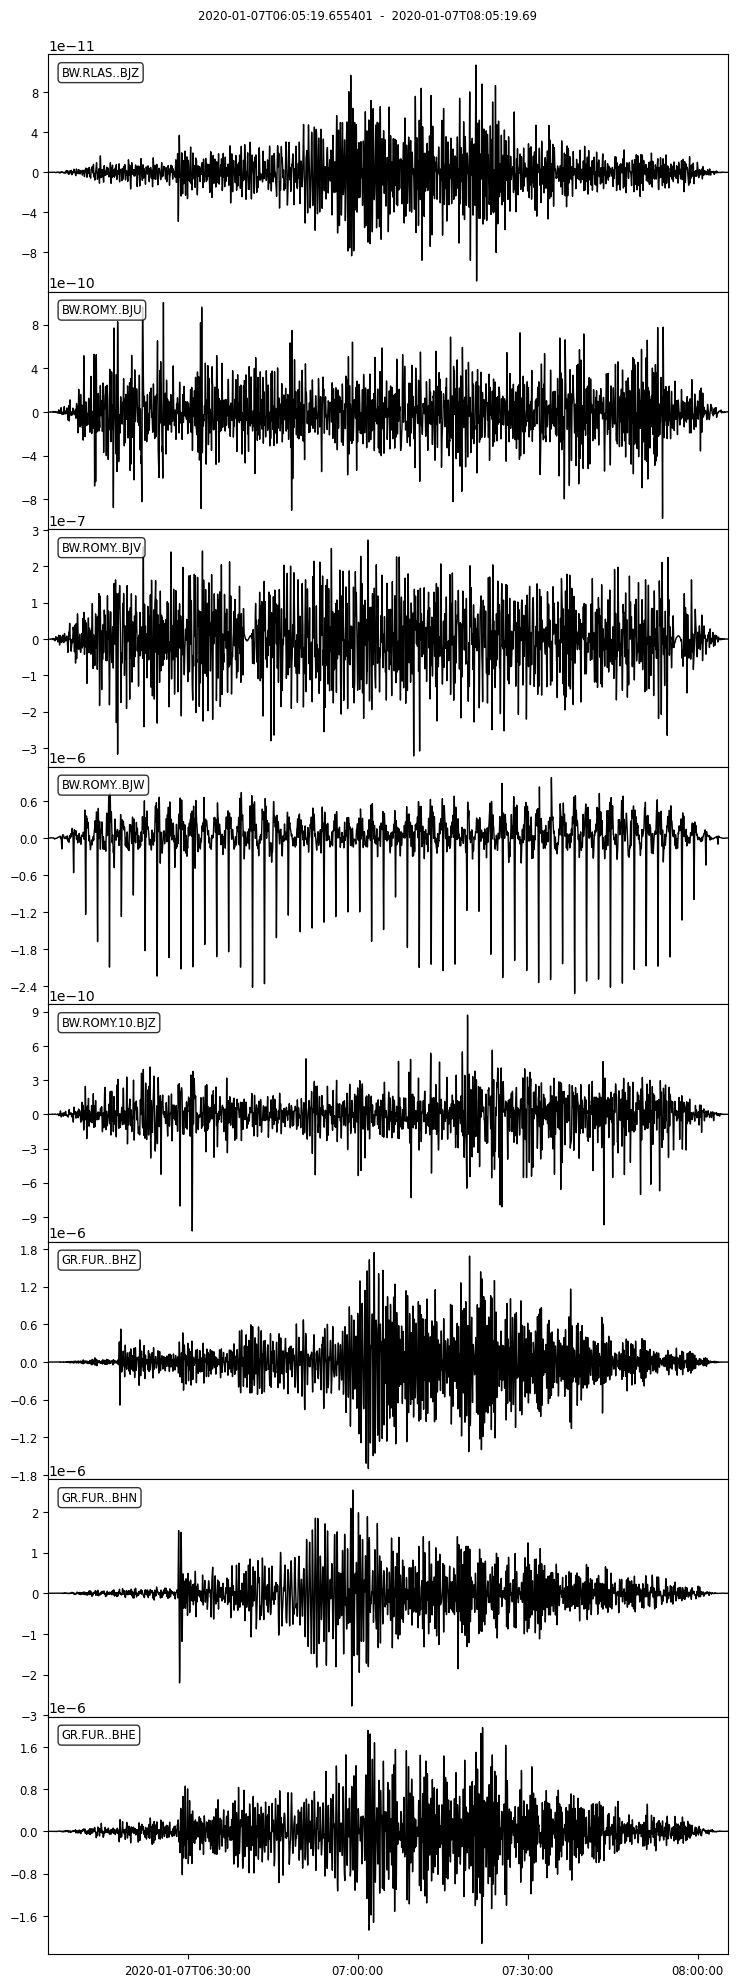


 -> 001 2020-01-07 08:24:25.120000 


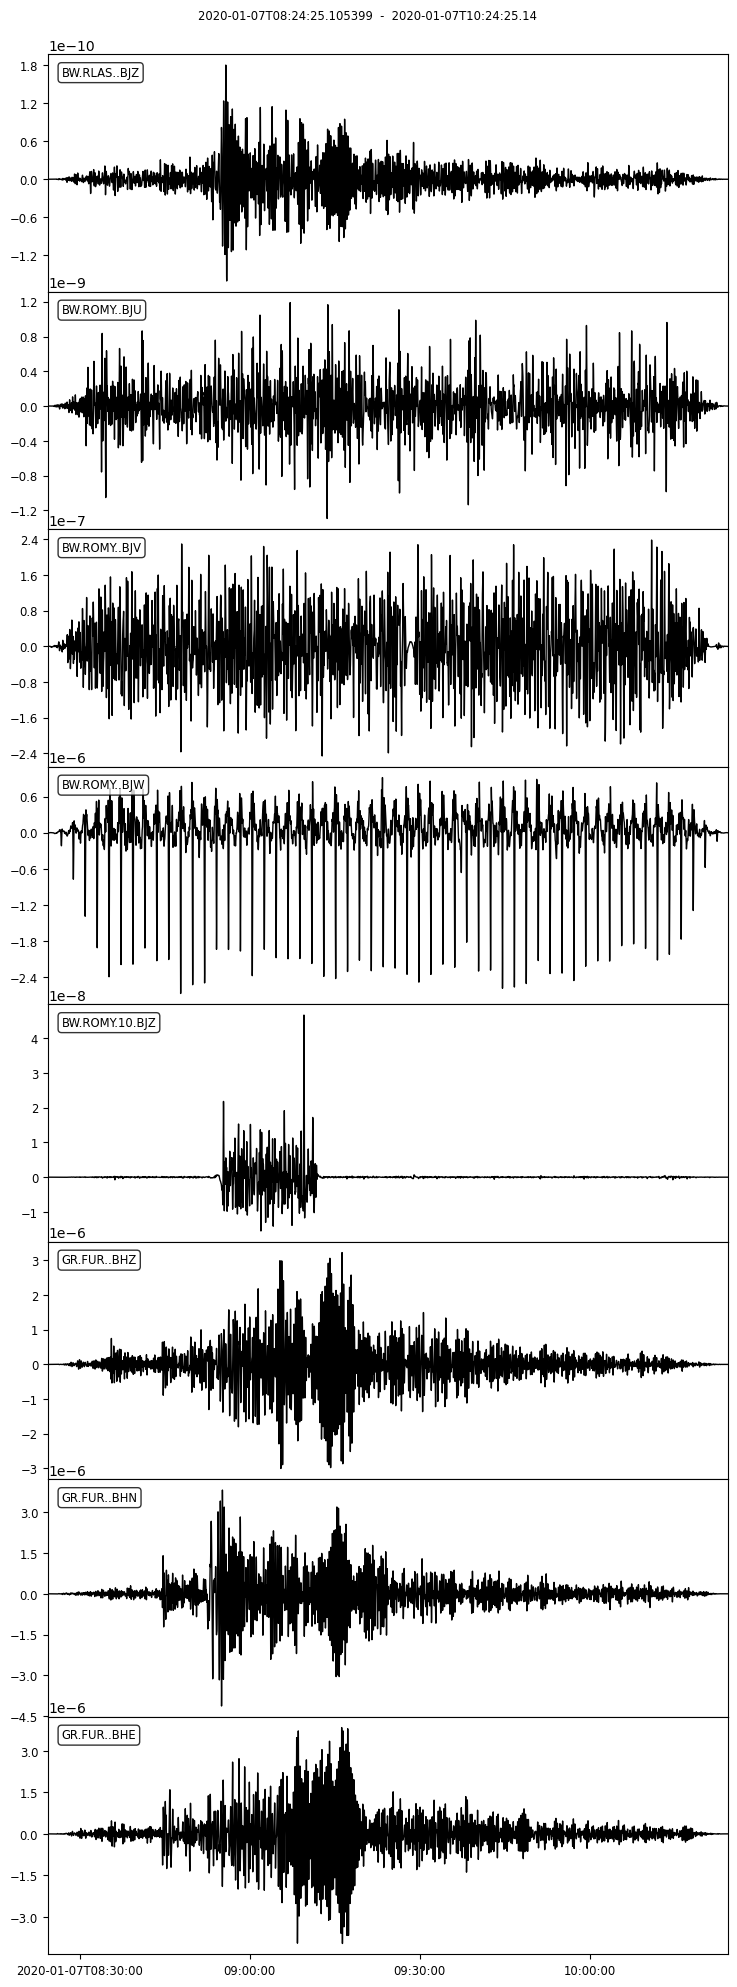

In [ ]:
global errors

errors = []
adr_status = []


for jj in range(events.shape[0]):
# for jj, ev in enumerate(events[:1]):

    num = str(jj).rjust(3, "0")

    print(f"\n -> {num} {events.origin.iloc[jj]} ")

    try:
        event_name = str(events.origin.iloc[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]
    except:
        print(f" -> {num}: error for {events.origin.iloc[jj]}")
        continue


#     ## check if file already exists
#     filename = config['outpath_figs']+"raw/"+f"{event_name}_raw.png"
#     if os.path.isfile(filename):
#         print(f" -> file alread exits for {event_name}")
#         continue

    ## configuration adjustments
    config['title'] = f"{num}_{events.origin.iloc[jj]} UTC | M{events.magnitude.iloc[jj]}"
    config['tbeg'] = obs.UTCDateTime(str(events.origin.iloc[jj]))


    # ## select appropriate seismometer
    # if config['tbeg'].date < obs.UTCDateTime("2023-04-01"):
    #     config['seed_seismometer'] = config['seed_seismometer1']
    #     config['fmin'], config['fmax'] = 0.01, 18.0
    # else:
    #     config['seed_seismometer'] = config['seed_seismometer2']
    #     config['fmin'], config['fmax'] = 0.01, 80.0


    ## same endtime for all
    config['tend'] = obs.UTCDateTime(events.origin.iloc[jj]) + config['duration']


    st0 = obs.Stream()

    for seed in config['seeds']:

        if "FUR" in seed:
            repo = "jane"
        else:
            repo = "george"

        try:
            stx, invx = __querrySeismoData( seed_id=seed,
                                            starttime=config['tbeg'],
                                            endtime=config['tend'],
                                            repository=repo,
                                            path=None,
                                            restitute=True,
                                            detail=None,
                                            fill_value=None,
                                          )
            st0 += stx

        except Exception as e:
            print(e)
            print(f" -> failed to request {seed} for event: {events.origin.iloc[jj]}")
            errors.append(f" -> failed to request {seed} for event: {events.origin.iloc[jj]}")
            continue



    st0 = st0.sort()

    ## processing data stream
    st = st0.copy();
    st = st.detrend("linear");
    st = st.taper(0.1);
    st = st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);


    st = st.trim(config['tbeg'], config['tend']);

    st0 = st0.trim(config['tbeg'], config['tend']);

    st.plot(equal_scale=False);

    ## store waveform data
#     num = str(jj).rjust(3, "0")
#     waveform_filename = f"ACC/{num}_{str(events.origin[jj]).split('.')[0].replace('-','').replace(':','').replace(' ','_')}.mseed"
#     st0.write(config['outpath_data']+waveform_filename, format="MSEED");

#     ## store waveform data as vel / rad
#     waveform_filename = f"VEL/{num}_{str(events.origin[jj]).split('.')[0].replace('-','').replace(':','').replace(' ','_')}.mseed"
#     st00 = st0.copy()
#     st00.integrate(method='spline')
#     st00.write(config['outpath_data']+waveform_filename, format="MSEED");



    ## plotting figures
    fig1 = st0.plot(equal_scale=False, show=False);
    fig2 = st.plot(equal_scale=False, show=False);

    ## saving figures
    fig1.savefig(config['outpath_figs']+"raw/"+f"{num}_{event_name}_raw.png", dpi=150, bbox_inches='tight', pad_inches=0.05)
    fig2.savefig(config['outpath_figs']+"filtered/"+f"{num}_{event_name}_filtered.png", dpi=150, bbox_inches='tight', pad_inches=0.05)




In [ ]:
pprint(errors)

## Make StatusPlot for ADR

In [ ]:
config['array_stations'] = ['II.PFO','PY.BPH01','PY.BPH02','PY.BPH03','PY.BPH04','PY.BPH05','PY.BPH06','PY.BPH07',
                            'PY.BPH08','PY.BPH09','PY.BPH10','PY.BPH11','PY.BPH12','PY.BPH13']


import matplotlib.colors

fig, ax = plt.subplots(1,1,figsize=(15,5))

cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])

ax.pcolormesh(np.array(adr_status).T, cmap=cmap, edgecolors="k", lw=0.5)

ax.set_yticks(np.arange(0,len(config['array_stations']))+0.5, labels=config['array_stations'])

ax.set_xlabel("Event No.",fontsize=12)

plt.show();

## Testing Signal-to-Noise ratios

In [ ]:
# from numpy import nanmean, sqrt

# win_length_sec = 10 ## seconds

# t_trigger = events.trigger_time[jj]
# t_rel_sec = t_trigger-config['tbeg']
# fig, ax = plt.subplots(len(st0),1, figsize=(15,15))

# for i, tr in enumerate(st0):

#     df = tr.stats.sampling_rate

#     NN = int(df * win_length_sec) ## samples

#     t_rel_spl = t_rel_sec*df ## samples

#     t_offset = df * 2 ## samples

#     noise = nanmean(tr.data[int(t_rel_spl-NN):int(t_rel_spl)]**2)
#     signal = nanmean(tr.data[int(t_rel_spl):int(t_rel_spl+NN)]**2)

#     SNR = sqrt(signal/noise)



#     ax[i].plot(tr.data)

#     ax[i].axvline(t_rel_spl, color="red")
#     ax[i].axvline(t_rel_spl+NN, color="red")

#     ax[i].axvline(t_rel_spl, color="g")
#     ax[i].axvline(t_rel_spl-NN, color="g")

#     print(SNR)

# plt.show();
